# Pose estimation for Gradient Boost Classifier
Using [the MediaPipe Human Pose Estimation Model](https://sigmoidal.ai/en/real-time-human-pose-estimation-using-mediapipe/) to get a pose estimation to then process further for a simpler classification model, to classify tennis stroke types (forhand, backhand, serve). The goal is to only use the output of the pose estimation to train a very simple model.

Also the gradient boost model should be a generic classifier, which takes limb positons as input. So there the user only needs to find a good pose estimator model.

In [146]:
import random
from pathlib import Path
from typing import Callable

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mediapipe as mp
import cv2

total files: 705
random file chosen C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\forehand\seq_033\F_033_000.jpeg


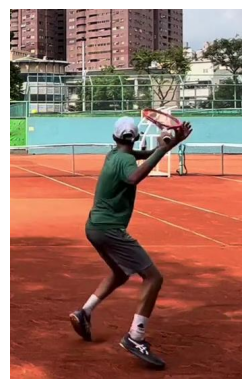

In [66]:
# load random image
DATA_PATH = Path(
    r"C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped")
DATA_PATH_CUSTOM_PICTURES = Path(
    r"C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel"
)

all_file_paths = []
for path in DATA_PATH.glob("**/*"):
    if path.is_file() and path.suffix == ".jpeg":
        all_file_paths.append(path)

all_file_paths_custom_pictures = []
for path in DATA_PATH_CUSTOM_PICTURES.glob("**/*"):
    if path.is_file() and path.suffix == ".jpg":
        all_file_paths_custom_pictures.append(path)

print(f"total files: {len(all_file_paths)}")
random_file_path = random.choice(all_file_paths)
print(f"random file chosen {random_file_path}")

random_image = cv2.imread(str(random_file_path))
random_image_width = random_image.shape[1]
random_image_height = random_image.shape[0]

fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(random_image[..., ::-1])

# Pose estimation
The idea is, to use a pose estimator to locate important body parts and then use these values to train a much simpler model.

In [8]:
def plot_key_points(ax, pose_model, image, image_name):
    image_width = image.shape[1]
    image_height = image.shape[0]
    # mp_drawing = mp.solutions.drawing_utils
    # annotated_img = image.copy()
    # Processes the image.
    results = pose_model.process(image)
    # Set the circle radius for drawing the 'landmarks'.
    # The radius is scaled as a percentage of the image's height.
    # circle_radius = int(.007 * image_height)
    # Specifies the drawing style for the 'landmarks'.
    # point_spec = mp_drawing.DrawingSpec(color=(220, 100, 0), thickness=-1, circle_radius=circle_radius)
    # Draws the 'landmarks' on the image.
    # mp_drawing.draw_landmarks(annotated_img,
    #                           landmark_list=results.pose_landmarks,
    #                           landmark_drawing_spec=point_spec)

    # Select the coordinates of the points of interest.
    l_shoulder_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width)
    l_shoulder_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height)
    l_elbow_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x * image_width)
    l_elbow_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y * image_height)
    l_wrist_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * image_width)
    l_wrist_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * image_height)
    l_hip_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x * image_width)
    l_hip_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y * image_height)

    r_shoulder_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width)
    r_shoulder_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height)
    r_elbow_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x * image_width)
    r_elbow_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y * image_height)
    r_wrist_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * image_width)
    r_wrist_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * image_height)
    r_hip_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * image_width)
    r_hip_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * image_height)

    l_ear_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x * image_width)
    l_ear_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y * image_height)
    r_ear_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].x * image_width)
    r_ear_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].y * image_height)

    ax.set_axis_off()
    ax.imshow(image[:, :, ::-1])
    # left side marked red
    ax.plot([l_shoulder_x, l_elbow_x, l_wrist_x, l_hip_x, l_ear_x],
            [l_shoulder_y, l_elbow_y, l_wrist_y, l_hip_y, l_ear_y], 'ro')
    # right side marked blue
    ax.plot([r_shoulder_x, r_elbow_x, r_wrist_x, r_hip_x, r_ear_x],
            [r_shoulder_y, r_elbow_y, r_wrist_y, r_hip_y, r_ear_y], 'bo')
    ax.set_title(image_name)


In [117]:
mp_pose = mp.solutions.pose

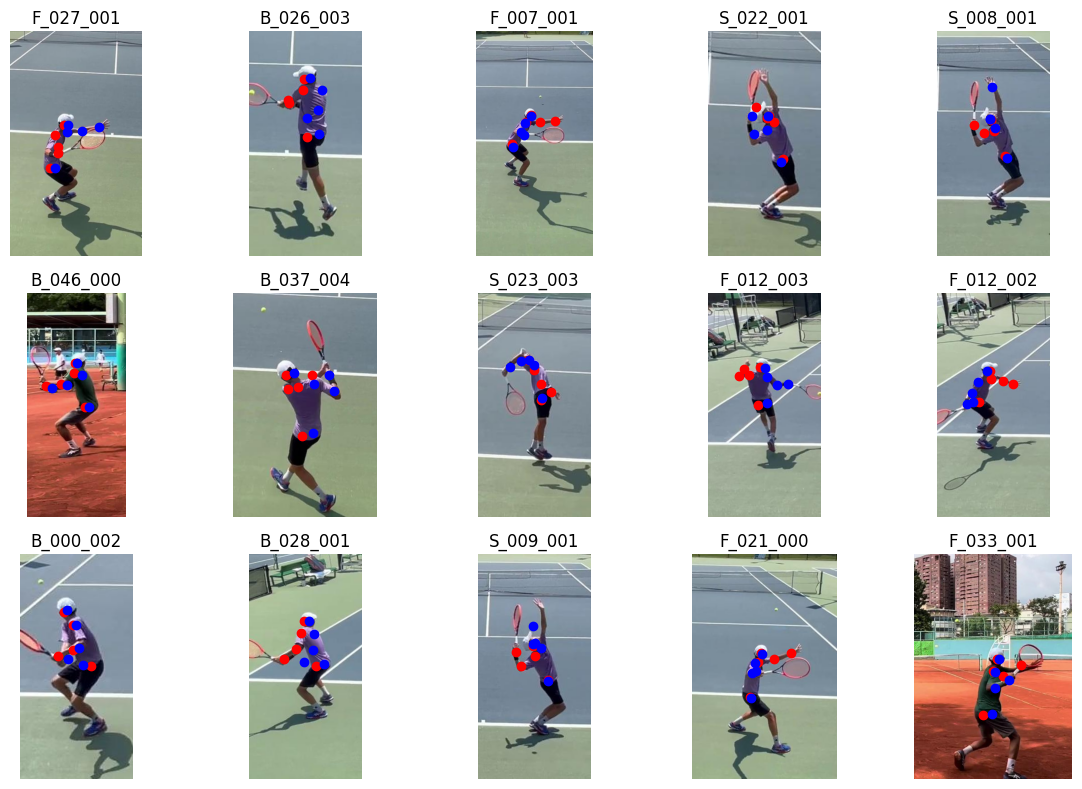

In [15]:
n_rows = 3
n_cols = 5

random_file_paths = random.sample(all_file_paths, n_rows * n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))

with mp_pose.Pose(static_image_mode=True) as pose_model:
    for index, random_file_path in enumerate(random_file_paths):
        row_index = index // n_cols
        col_index = index % n_cols
        ax = axs[row_index][col_index]
        image_name = random_file_path.stem
        image = cv2.imread(str(random_file_path))
        plot_key_points(ax, pose_model, image, image_name)

fig.tight_layout()

plt.show()


- Right key points: Blue
- Left key points: Red

As you can see, this works pretty well. Hips and shoulders are mostly recognized correctly. These are also meant to be considered the most important body parts from our domain expert. But we will see, what "features" exactly will be the most important.

For some of the pictures, no pose could have been estimated.

**CAUTION:**
A very important thing at this point would also be to properly evaluate the pose estimation model. Due to the limited time for this project, we simply suppose the pose estimation model to perform good enough for our task.

# Define Features
We define the shoulder, elbow, wrist and ear position on each side relative to the hips middle position (hips left and hips right) normalized to the image size.

X-Axis: A negative value indicates its position is on the **left** of the hip center

Y-Axis: A negative value indicates its position is **below** the hip center


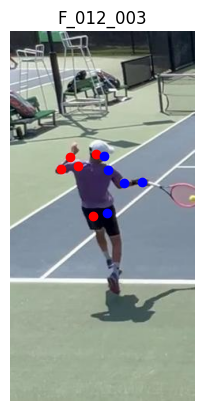

In [27]:
feature_demo_file_path = DATA_PATH.joinpath("forehand/seq_012/F_012_003.jpeg")

fig, ax = plt.subplots()
with mp_pose.Pose(static_image_mode=True) as pose_model:
    image = cv2.imread(str(feature_demo_file_path))
    plot_key_points(ax, pose_model, image, feature_demo_file_path.stem)


## Feature extractor
These methods below will extract every features (body parts positions in relative to the hip center) of every image.
The following body part positions relative to the hips center as x- and y-coordinates will be used as features:
- left and right shoulder
- left and right elbow
- left and right wrist

Addidionally some metainformation will also be contained in the frame. Some as features, some only for information.
- Sequence Identifier (Initially the goal was to use a sequence of 5 images to determine one type of tennis hit. Every sequence of 5 images received a sequence identifier)
- Index in Sequence --> The position of the image in the sequence of 5 images (might be important for the model)
- Label
- File path of the source file

In [67]:
def get_pose_features_of_image(pose_estimator, image_path: Path, data_augmentation_function: Callable | None = None) -> \
        dict[str, float]:
    image = cv2.imread(str(image_path))
    if data_augmentation_function is not None:
        image = data_augmentation_function(image)
    results = pose_estimator.process(image)

    if results.pose_landmarks is None:
        print(f"FAILED FOR IMAGE {image_path}")
        return {"relLeftShoulderX": np.nan,
                "relLeftShoulderY": np.nan,
                "relLeftElbowX": np.nan,
                "relLeftElbowY": np.nan,
                "relLeftWristX": np.nan,
                "relLeftWristY": np.nan,
                "relRightShoulderX": np.nan,
                "relRightShoulderY": np.nan,
                "relRightElbowX": np.nan,
                "relRightElbowY": np.nan,
                "relRightWristX": np.nan,
                "relRightWristY": np.nan}

    l_hip_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x
    l_hip_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y

    r_hip_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x
    r_hip_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y

    center_hip_x = (l_hip_x + r_hip_x) / 2
    center_hip_y = (l_hip_y + r_hip_y) / 2

    l_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x
    l_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y
    l_elbow_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x
    l_elbow_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y
    l_wrist_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x
    l_wrist_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y

    r_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x
    r_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y
    r_elbow_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x
    r_elbow_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y
    r_wrist_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x
    r_wrist_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y

    return {"relLeftShoulderX": l_shoulder_x - center_hip_x,
            "relLeftShoulderY": l_shoulder_y - center_hip_y,
            "relLeftElbowX": l_elbow_x - center_hip_x,
            "relLeftElbowY": l_elbow_y - center_hip_y,
            "relLeftWristX": l_wrist_x - center_hip_x,
            "relLeftWristY": l_wrist_y - center_hip_y,
            "relRightShoulderX": r_shoulder_x - center_hip_x,
            "relRightShoulderY": r_shoulder_y - center_hip_y,
            "relRightElbowX": r_elbow_x - center_hip_x,
            "relRightElbowY": r_elbow_y - center_hip_y,
            "relRightWristX": r_wrist_x - center_hip_x,
            "relRightWristY": r_wrist_y - center_hip_y}


def get_pose_features(pose_estimator, folder_path: Path, initial_dataframe: pd.DataFrame | None = None,
                      image_pattern: str = "*.jpeg",
                      data_augmentation_function: Callable | None = None) -> pd.DataFrame:
    label = folder_path.name
    features = []
    for sequence_folder in folder_path.iterdir():
        if not sequence_folder.is_dir():
            continue
        sequence_identifier = int(sequence_folder.name.split("_")[1])
        for image_path in sequence_folder.glob(image_pattern):
            index_in_sequence = int(image_path.stem.split("_")[2])

            image_features = get_pose_features_of_image(pose_estimator, image_path, data_augmentation_function)
            image_features.update({"sequenceIdentifier": sequence_identifier,
                                   "indexInSequence": index_in_sequence,
                                   "label": label,
                                   "filePath": str(image_path)})

            features.append(image_features)

    new_pose_features = pd.DataFrame(features)
    if initial_dataframe is not None:
        return pd.concat([initial_dataframe, new_pose_features]).reset_index(drop=True)

    return new_pose_features

Get the features for every image from the image collection found online

In [34]:
with mp_pose.Pose(static_image_mode=True) as pose_estimator:
    pose_features = get_pose_features(pose_estimator, DATA_PATH.joinpath("backhand"))
    pose_features = get_pose_features(pose_estimator, DATA_PATH.joinpath("forehand"), initial_dataframe=pose_features)
    pose_features = get_pose_features(pose_estimator, DATA_PATH.joinpath("serve"), initial_dataframe=pose_features)

pose_features.sample(10)

C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_020\B_020_004.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_044\B_044_000.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_048\B_048_003.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\forehand\seq_014\F_014_003.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_cla

relLeftShoulderX  relLeftShoulderY  relLeftElbowX  relLeftElbowY  \
590         -0.036711         -0.178733      -0.071808      -0.258573   
553         -0.125156         -0.165572      -0.093729      -0.230305   
453          0.013918         -0.163398      -0.091767      -0.151382   
499         -0.013379         -0.137279      -0.121615      -0.106553   
569         -0.189294         -0.079659      -0.130739      -0.019889   
561         -0.178581         -0.085045      -0.307126      -0.059908   
243               NaN               NaN            NaN            NaN   
502          0.148860         -0.116536       0.267731      -0.108356   
678         -0.136193         -0.068735      -0.029914      -0.051168   
451          0.080941         -0.087486       0.168402      -0.068214   

     relLeftWristX  relLeftWristY  relRightShoulderX  relRightShoulderY  \
590      -0.111427      -0.350373          -0.142644          -0.122121   
553      -0.233021      -0.245516          -0.131296          -0.172637   
453      -0.022075      -0.172008           0.173835          -0.112523   
499      -0.123212      -0.126957           0.197747          -0.123380   
569      -0.065501      -0.005417          -0.035150          -0.104759   
561      -0.341252      -0.123603          -0.099816          -0.138256   
243            NaN            NaN                NaN                NaN   
502       0.365897      -0.104764           0.159207          -0.107585   
678       0.062786      -0.052216          -0.118083          -0.114503   
451       0.259667      -0.053580           0.111792          -0.083951   

     relRightElbowX  relRightElbowY  relRightWristX  relRightWristY  \
590       -0.227864       -0.079792       -0.240394       -0.124892   
553       -0.155649       -0.282426       -0.285609       -0.250969   
453        0.195223       -0.029394        0.316851        0.006615   
499        0.137174       -0.113207        0.050104       -0.135798   
569        0.041574       -0.050702        0.012412       -0.020693   
561       -0.113510       -0.213358       -0.159011       -0.292597   
243             NaN             NaN             NaN             NaN   
502        0.111141       -0.049659        0.129644        0.002131   
678       -0.068380       -0.169608       -0.021591       -0.221506   
451        0.206126       -0.073190        0.307153       -0.072895   

     sequenceIdentifier  indexInSequence     label  \
590                   9                0     serve   
553                   1                3     serve   
453                  29                3  forehand   
499                  38                4  forehand   
569                   4                4     serve   
561                   3                1     serve   
243                  48                3  backhand   
502                  39                2  forehand   
678                  26                3     serve   
451                  29                1  forehand   

                                              filePath  
590  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
553  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
453  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
499  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
569  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
561  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
243  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
502  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
678  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
451  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...

In [35]:
# Write to pickle to not always have to recalculate
pose_features.to_pickle("pose_features.pkl")

Do the same with the self made data set by Gabriel Guerra.

In [36]:
with mp_pose.Pose(static_image_mode=True) as pose_estimator:
    pose_features_custom_pictures = get_pose_features(pose_estimator, DATA_PATH_CUSTOM_PICTURES.joinpath("backhand"),
                                                      image_pattern="*.jpg")
    pose_features_custom_pictures = get_pose_features(pose_estimator, DATA_PATH_CUSTOM_PICTURES.joinpath("forehand"),
                                                      initial_dataframe=pose_features_custom_pictures,
                                                      image_pattern="*.jpg")
    pose_features_custom_pictures = get_pose_features(pose_estimator, DATA_PATH_CUSTOM_PICTURES.joinpath("serve"),
                                                      initial_dataframe=pose_features_custom_pictures,
                                                      image_pattern="*.jpg")

pose_features_custom_pictures.sample(10)

C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_000\S_000_003.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_005\S_005_002.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_007\S_007_002.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_020\S_020_002.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Te

relLeftShoulderX  relLeftShoulderY  relLeftElbowX  relLeftElbowY  \
395         -0.061128         -0.118467      -0.011548      -0.079767   
422         -0.064673         -0.116640      -0.052254      -0.159063   
11          -0.052020         -0.089168      -0.045211      -0.031731   
85          -0.034171         -0.115906      -0.063988      -0.059149   
97          -0.002333         -0.087302       0.059527      -0.043722   
17          -0.125122         -0.071548      -0.096722      -0.029961   
405         -0.046172         -0.130628      -0.014088      -0.162417   
394         -0.156511         -0.065054      -0.156299      -0.014998   
364         -0.051127         -0.126617      -0.098081      -0.076411   
137          0.001696         -0.088295       0.037087      -0.045065   

     relLeftWristX  relLeftWristY  relRightShoulderX  relRightShoulderY  \
395       0.019472      -0.120845          -0.037251          -0.120702   
422      -0.030394      -0.201577          -0.092612          -0.099517   
11       -0.065927      -0.014396          -0.024610          -0.105204   
85       -0.129487      -0.058093           0.024788          -0.114749   
97        0.004771      -0.001491          -0.057345          -0.086122   
17       -0.115783       0.011625          -0.094861          -0.068736   
405       0.011904      -0.201144          -0.079386          -0.117299   
394      -0.137207      -0.047052          -0.066861          -0.116502   
364      -0.130599      -0.109491           0.051783          -0.139193   
137      -0.019160      -0.009632          -0.017612          -0.090133   

     relRightElbowX  relRightElbowY  relRightWristX  relRightWristY  \
395        0.009215       -0.057561        0.082778       -0.015521   
422       -0.109717       -0.097457       -0.102622       -0.152977   
11        -0.065167       -0.058495       -0.089621       -0.032091   
85        -0.005622       -0.063127       -0.078654       -0.047009   
97        -0.059929       -0.049821       -0.104445       -0.026191   
17        -0.051477       -0.035691       -0.042448        0.001814   
405       -0.075878       -0.063975        0.004225       -0.024320   
394       -0.022670       -0.147060       -0.023771       -0.177139   
364        0.002591       -0.125697       -0.068598       -0.148067   
137       -0.027052       -0.052251       -0.066668       -0.032803   

     sequenceIdentifier  indexInSequence     label  \
395                   1                0     serve   
422                   6                2     serve   
11                    2                1  backhand   
85                   17                0  backhand   
97                   19                2  backhand   
17                    3                2  backhand   
405                   3                0     serve   
394                   0                4     serve   
364                  21                4  forehand   
137                  27                2  backhand   

                                              filePath  
395  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
422  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
11   C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
85   C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
97   C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
17   C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
405  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
394  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
364  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...  
137  C:\Users\simu_\OneDrive\Dokumente\Studium Weit...

In [37]:
pose_features_custom_pictures.to_pickle("pose_features_custom_pictures.pkl")

# Modelling

### Clean up Data
As we could see, some of the images could not be processed, they need to be dropped from the feature table.
In total these clean up tasks need to be done to the feature dataset:
- Map class labels to numbers
- Drop every row containing only NaN values.
- Drop the sequence identifier as it does not contain any relevant information

In [38]:
pose_features = pd.read_pickle("pose_features.pkl")

# map class labels to numbers
class_mapping = {"forehand": 1,
                 "backhand": 2,
                 "serve": 3}

pose_features_processed = pose_features.copy()
pose_features_processed["label"] = pose_features["label"].map(class_mapping)
pose_features_processed = pose_features_processed.dropna()
pose_features_processed = pose_features_processed.drop("sequenceIdentifier", axis=1)
pose_features_paths = pose_features_processed.pop("filePath")

pose_features_processed.sample(10)

relLeftShoulderX  relLeftShoulderY  relLeftElbowX  relLeftElbowY  \
369         -0.142413         -0.121726      -0.185705      -0.066945   
473         -0.079223         -0.191349      -0.162446      -0.155612   
700         -0.137519         -0.099962      -0.249786      -0.073908   
384         -0.073423         -0.142054      -0.148520      -0.082874   
345          0.041068         -0.152902       0.193751      -0.176356   
583         -0.205312         -0.166964      -0.239829      -0.206929   
448          0.004148         -0.110291      -0.084323      -0.098836   
665         -0.182599         -0.118634      -0.314135      -0.080909   
45          -0.135452         -0.180432      -0.170982      -0.097768   
703         -0.108149         -0.153096      -0.057657      -0.082293   

     relLeftWristX  relLeftWristY  relRightShoulderX  relRightShoulderY  \
369      -0.144735      -0.108084          -0.006561          -0.144450   
473      -0.119114      -0.179630           0.077892          -0.168242   
700      -0.317029      -0.123112          -0.065059          -0.144330   
384      -0.158837      -0.139066           0.042610          -0.163889   
345       0.344669      -0.209334           0.053774          -0.136904   
583      -0.300241      -0.234995          -0.103218          -0.215653   
448      -0.038766      -0.109222           0.123678          -0.080865   
665      -0.349538      -0.157757          -0.103105          -0.163608   
45       -0.277007      -0.043311          -0.077644          -0.179773   
703       0.008848      -0.047244          -0.111532          -0.163135   

     relRightElbowX  relRightElbowY  relRightWristX  relRightWristY  \
369       -0.063852       -0.135478       -0.159113       -0.148514   
473        0.138991       -0.091417        0.244277       -0.060432   
700       -0.135307       -0.151173       -0.233833       -0.179025   
384       -0.049862       -0.209671       -0.188526       -0.253562   
345        0.046182       -0.072365        0.159198       -0.083238   
583       -0.103803       -0.320449       -0.242288       -0.278665   
448        0.143544       -0.025264        0.225364        0.005270   
665       -0.174570       -0.216703       -0.222141       -0.321018   
45        -0.129065       -0.093106       -0.243599       -0.045918   
703       -0.170794       -0.131732       -0.152931       -0.138397   

     indexInSequence  label  
369                4      1  
473                3      1  
700                0      3  
384                4      1  
345                0      1  
583                3      3  
448                3      1  
665                0      3  
45                 0      2  
703                3      3

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    pose_features_processed.loc[:, pose_features_processed.columns != "label"], pose_features_processed["label"],
    stratify=pose_features_processed["label"], test_size=0.2, random_state=3)

print(f"Training size: {X_train.shape}")
print(f"Testing size: {X_test.shape}")

Training size: (554, 13)
Testing size: (139, 13)


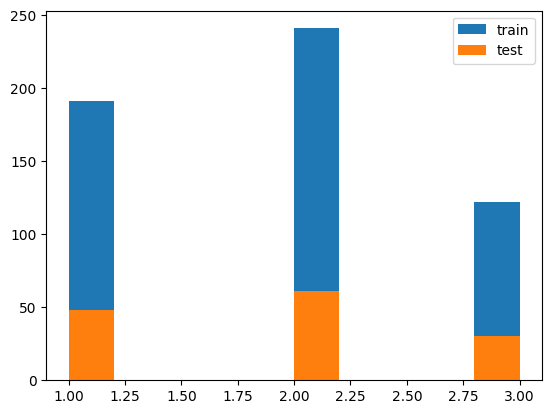

In [40]:
fig, ax = plt.subplots()
ax.hist(y_train, label="train")
ax.hist(y_test, label="test")
ax.legend()

# Model: Gradient Boost Classifier

Gradient Boost Classifier is used because it can handle very few input features and is easy to use.

In [41]:
params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.01,
    "verbose": 1,
    "subsample": 0.8
}

gbc_model = GradientBoostingClassifier(**params)
gbc_model

GradientBoostingClassifier(learning_rate=0.01, subsample=0.8, verbose=1)

In [42]:
gbc_model.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.0486           0.0131            3.52s
         2           1.0274          -0.0119            2.11s
         3           1.0132           0.0138            1.62s
         4           1.0084           0.0489            1.35s
         5           0.9858          -0.0225            1.18s
         6           0.9837           0.0561            1.07s
         7           0.9701           0.0121            0.95s
         8           0.9509          -0.0204            0.82s
         9           0.9426           0.0286            0.72s
        10           0.9266          -0.0029            0.78s
        20           0.8221           0.0203            0.60s
        30           0.7342           0.0209            0.46s
        40           0.6607           0.0216            0.39s
        50           0.5890          -0.0235            0.33s
        60           0.5359          -0.0091            0.28s
       

GradientBoostingClassifier(learning_rate=0.01, subsample=0.8, verbose=1)

Score on train set:

In [50]:
gbc_model.score(X_train, y_train)

0.9602888086642599

In [52]:
accuracies_train = []
for y_pred_train in gbc_model.staged_predict(X_train):
    acc = accuracy_score(y_train, y_pred_train)
    accuracies_train.append(acc)

accuracies_test = []
for y_pred_test in gbc_model.staged_predict(X_test):
    acc = accuracy_score(y_test, y_pred_test)
    accuracies_test.append(acc)


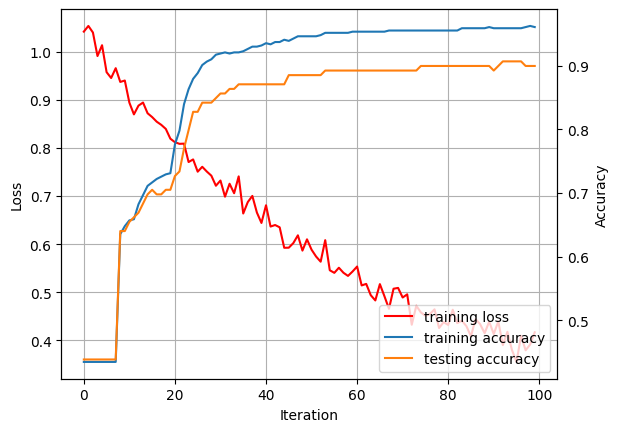

In [59]:
loss_values = gbc_model.oob_scores_

fig, ax = plt.subplots()
line1, = ax.plot(loss_values, label="training loss", color="r")
ax.set_ylabel("Loss")
ax.set_xlabel("Iteration")
ax.grid(True)
ax2 = ax.twinx()
line2, = ax2.plot(accuracies_train, label="training accuracy")
line3, = ax2.plot(accuracies_test, label="testing accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(handles=[line1, line2, line3])
plt.show()

The accuracy seem to saturate quite quickly. But it definitely learns something! Not that good but the model is still improvable.

Also to get an idea about the accuracy, the confusion matrix is useful:

[Text(0, 0, 'forehand'), Text(0, 1, 'backhand'), Text(0, 2, 'serve')]

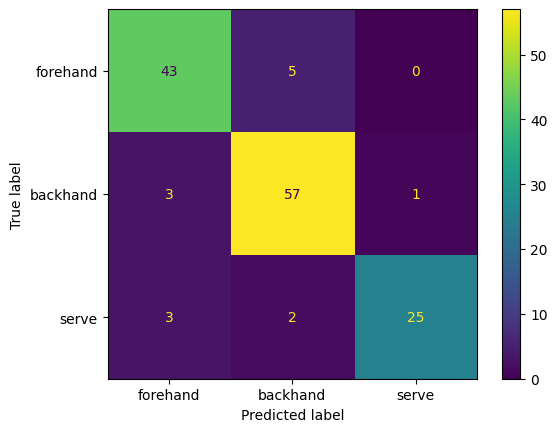

In [60]:
conf_matrix_plot_1 = ConfusionMatrixDisplay.from_estimator(gbc_model, X_test, y_test)
conf_matrix_plot_1.ax_.set_xticklabels(class_mapping.keys())
conf_matrix_plot_1.ax_.set_yticklabels(class_mapping.keys())

Another very handy feature of the gradient boost model, is to get feature importances. 

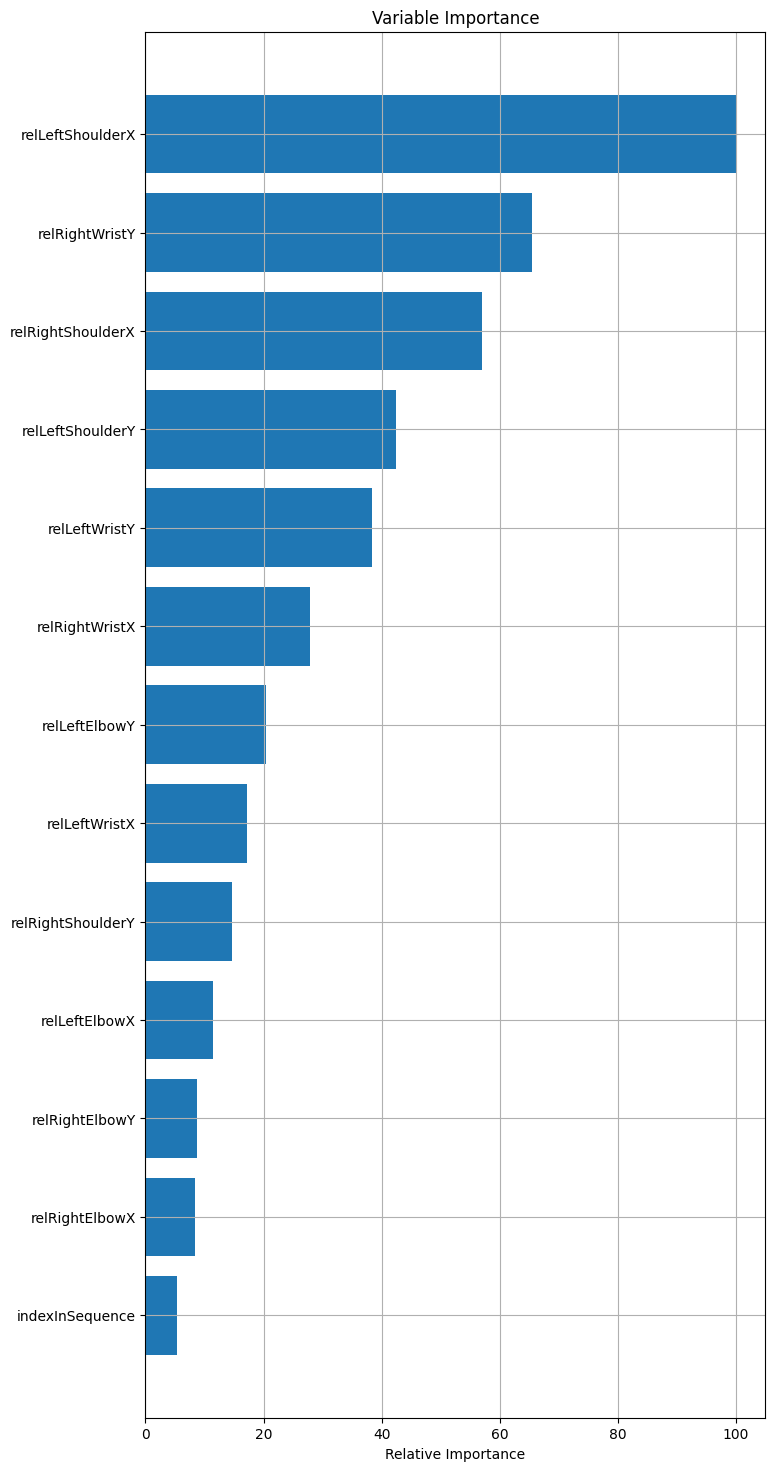

In [61]:
feature_importance = gbc_model.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid(True)
plt.show()

## Testing on custom Pictures
Now we also test the trained model on the custom made pictures, made by Gabriel Guerra.

In [62]:
pose_features_custom_pictures = pd.read_pickle("pose_features_custom_pictures.pkl")

# map class labels to numbers
class_mapping = {"forehand": 1,
                 "backhand": 2,
                 "serve": 3}

pose_features_custom_pictures_processed = pose_features_custom_pictures.copy()
pose_features_custom_pictures_processed["label"] = pose_features_custom_pictures["label"].map(class_mapping)
pose_features_custom_pictures_processed = pose_features_custom_pictures_processed.dropna()
pose_features_custom_pictures_processed = pose_features_custom_pictures_processed.drop("sequenceIdentifier", axis=1)
pose_features_custom_pictures_paths = pose_features_custom_pictures_processed.pop("filePath")

pose_features_custom_pictures_processed.sample(10)

relLeftShoulderX  relLeftShoulderY  relLeftElbowX  relLeftElbowY  \
179         -0.119429         -0.127351      -0.157639      -0.063962   
362         -0.014164         -0.134350      -0.071040      -0.115386   
365         -0.039417         -0.119751      -0.068059      -0.072121   
36           0.016793         -0.123044      -0.024627      -0.073614   
248         -0.019699         -0.094149       0.035151      -0.048403   
167         -0.046337         -0.102732       0.003027      -0.056974   
494         -0.147256         -0.050453      -0.090323      -0.017736   
320         -0.074333         -0.129005      -0.089212      -0.072530   
157         -0.043306         -0.087871      -0.001911      -0.038426   
155         -0.041869         -0.109611      -0.076422      -0.061962   

     relLeftWristX  relLeftWristY  relRightShoulderX  relRightShoulderY  \
179      -0.141205      -0.015395           0.041668          -0.141527   
362      -0.026061      -0.112919           0.121516          -0.097226   
365      -0.019331      -0.068631           0.095374          -0.113330   
36       -0.113570      -0.089231           0.016450          -0.115620   
248      -0.000136      -0.003669          -0.015550          -0.097387   
167      -0.039874      -0.012032          -0.061385          -0.100171   
494      -0.075851       0.019018          -0.103383          -0.066711   
320      -0.031602      -0.065764           0.095643          -0.125649   
157      -0.045469       0.001475          -0.046818          -0.090784   
155      -0.138030      -0.055487          -0.005305          -0.100654   

     relRightElbowX  relRightElbowY  relRightWristX  relRightWristY  \
179        0.144710       -0.123378        0.234510       -0.149361   
362        0.139399       -0.036479        0.215222       -0.018587   
365        0.156493       -0.050237        0.151738       -0.062301   
36        -0.036011       -0.074229       -0.114612       -0.063736   
248       -0.003114       -0.052887       -0.015580       -0.015168   
167       -0.064650       -0.052427       -0.129440       -0.030257   
494       -0.032706       -0.034796       -0.024534        0.000882   
320        0.127947       -0.060700        0.057427       -0.060652   
157       -0.036118       -0.042108       -0.071930       -0.010482   
155       -0.043744       -0.055184       -0.108909       -0.038545   

     indexInSequence  label  
179                4      2  
362                2      1  
365                0      1  
36                 1      2  
248                3      2  
167                2      2  
494                4      3  
320                0      1  
157                2      2  
155                0      2

In [63]:
X_custom_pictures = pose_features_custom_pictures_processed.loc[:,
                    pose_features_custom_pictures_processed.columns != "label"]
y_custom_pictures = pose_features_custom_pictures_processed["label"]

gbc_model.score(X_custom_pictures, y_custom_pictures)

0.7319932998324958

[Text(0, 0, 'forehand'), Text(0, 1, 'backhand'), Text(0, 2, 'serve')]

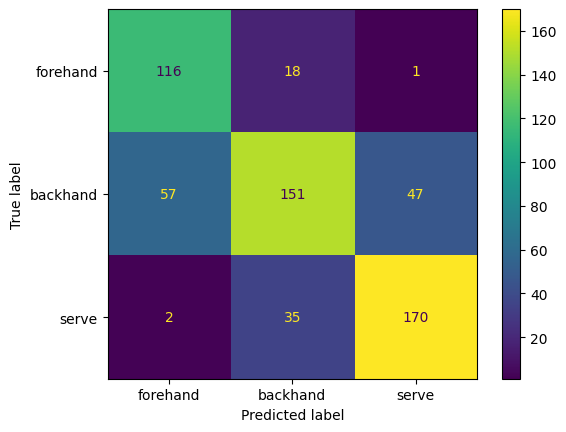

In [64]:
conf_matrix_plot = ConfusionMatrixDisplay.from_estimator(gbc_model, X_custom_pictures, y_custom_pictures)
conf_matrix_plot.ax_.set_xticklabels(class_mapping.keys())
conf_matrix_plot.ax_.set_yticklabels(class_mapping.keys())

### First Model summary
The first model was trained based on the online dataset. The model is able to learn and performs quite well on the test set of the same dataset.
But on the custom made dataset (custom pictures taken by Gabriel Guerra) however, the model does not perform that good. This might happen because of the following reasons:
#### 1. Mostly only one Person in online dataset
In the online Dataset there is mostly only one person playing on a picture. Very few pictures wer taken from other players. If other players use to play differently, it does not work that good.

**&#8594; Use custom dataset for training as well**
#### 2. Different Person Sizes
Even though the relative key point position to the hip center is normalized to the image size, the problem still arises, when the cropping is not done right. The size of the person in the picture compared to the image size is crutial to be the same. If it is not the same like demonstrated here:

<div>
<img src="person_size_problem.png" width="500"/>
</div>
As you can see the relative y-value of the wrist is the same on the picture on the left and right, even tough the person on the left is holding his arm up and the other down.

**&#8594; Standard scale data and use yeo-johnson transformation to work against bad cropped images**
#### 3. Different Image Quality and Angle
Images made by Gabriel Guerra have a better resolution and are taken from a slight different angle.

**&#8594; Data augmentation (slight rotation, adapt blurring, adjust brightness)**


## Regularization

## Data Augmentation
Images will be slightly rotated, the resolution changed a bit and also brightness changed a bit. Of course the pose estimation model must be checkes as well again after augmentation

In [110]:
random.seed(3)


# Define functions
def random_rotate_image(image, min_angle: float = -10, max_angle: float = 10, angle: float | None = None):
    if angle is None:
        angle = random.uniform(min_angle, max_angle)
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1.0)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


def random_quality(image, kernel_size: tuple[int, int] | None = None):
    kernel_sizes = [3, 5, 7, 9, 11]
    random_kernel = random.choice(kernel_sizes)
    if kernel_size is None:
        kernel_size = (random_kernel, random_kernel)
    return cv2.GaussianBlur(image, kernel_size, 0)


def random_brightness(image, min_brightness: int = -100, max_brightness: int = 100, brightness: int | None = None):
    if brightness is None:
        brightness = random.randint(min_brightness, max_brightness)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, brightness)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    return image


def random_augment_image(image):
    # sometimes use multiple augmentation functions sometimes just one or none
    num_functions_to_apply = random.randint(0, 3)
    functions = [random_rotate_image, random_quality, random_brightness]
    random.shuffle(functions)
    for i in range(num_functions_to_apply):
        image = functions[i](image)

    return image



Test on single image

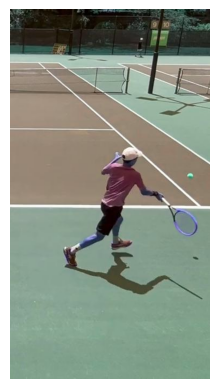

In [77]:
augment_image_sample_path = DATA_PATH.joinpath("forehand/seq_018/F_018_003.jpeg")

augment_image_sample = cv2.imread(str(augment_image_sample_path))

fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(augment_image_sample)
plt.show()

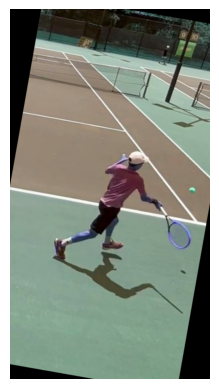

In [80]:
rotated_image = random_rotate_image(augment_image_sample, angle=-10)

fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(rotated_image)
plt.show()

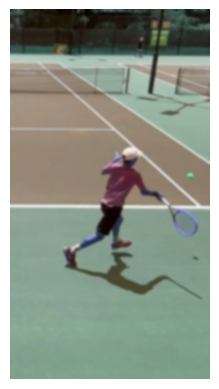

In [87]:
blurred_image = random_quality(augment_image_sample, kernel_size=(11, 11))

fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(blurred_image)
plt.show()

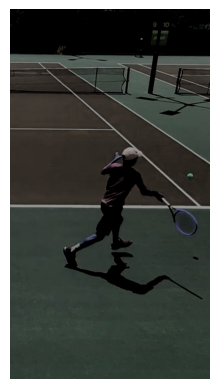

In [109]:
brighned_image = random_brightness(augment_image_sample, brightness=-100)

fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(brighned_image)
plt.show()

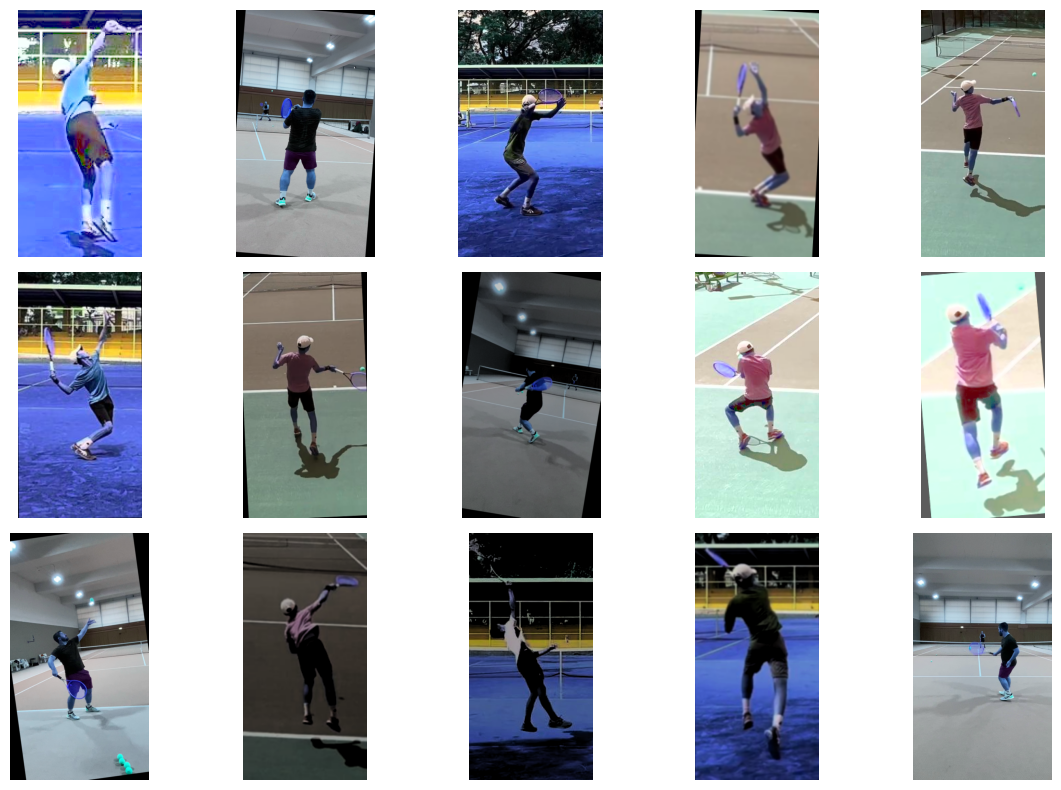

In [113]:
n_rows = 3
n_cols = 5

all_file_paths_with_custom_pictures = all_file_paths + all_file_paths_custom_pictures

random_file_paths = random.sample(all_file_paths_with_custom_pictures, n_rows * n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))

for index, random_file_path in enumerate(random_file_paths):
    row_index = index // n_cols
    col_index = index % n_cols
    ax = axs[row_index][col_index]
    ax.set_axis_off()
    image_name = random_file_path.stem
    image = cv2.imread(str(random_file_path))
    aug_image = random_augment_image(image)
    ax.imshow(aug_image)

fig.tight_layout()

plt.show()

Does pose estimation still work?

C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


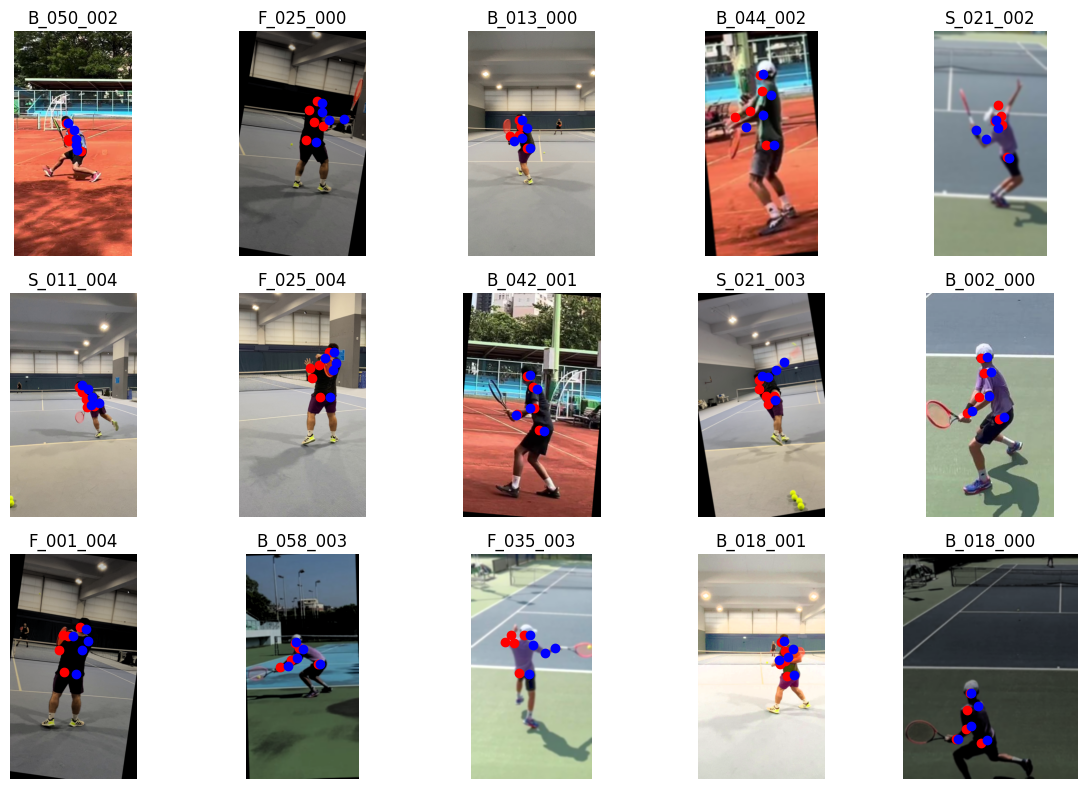

In [116]:
n_rows = 3
n_cols = 5

all_file_paths_with_custom_pictures = all_file_paths + all_file_paths_custom_pictures

random_file_paths = random.sample(all_file_paths_with_custom_pictures, n_rows * n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))

with mp_pose.Pose(static_image_mode=True) as pose_model:
    for index, random_file_path in enumerate(random_file_paths):
        row_index = index // n_cols
        col_index = index % n_cols
        ax = axs[row_index][col_index]
        image_name = random_file_path.stem
        image = cv2.imread(str(random_file_path))
        image = random_augment_image(image)
        plot_key_points(ax, pose_model, image, image_name)

fig.tight_layout()

plt.show()

Looks good. We will see, how many will fail afterwards.

### Create features with randomly augmented images

In [118]:
with mp_pose.Pose(static_image_mode=True) as pose_estimator:
    pose_features_with_aug = get_pose_features(pose_estimator, DATA_PATH.joinpath("backhand"),
                                               data_augmentation_function=random_augment_image)
    pose_features_with_aug = get_pose_features(pose_estimator, DATA_PATH.joinpath("forehand"),
                                               initial_dataframe=pose_features_with_aug,
                                               data_augmentation_function=random_augment_image)
    pose_features_with_aug = get_pose_features(pose_estimator, DATA_PATH.joinpath("serve"),
                                               initial_dataframe=pose_features_with_aug,
                                               data_augmentation_function=random_augment_image)

with mp_pose.Pose(static_image_mode=True) as pose_estimator:
    pose_features_custom_with_aug = get_pose_features(pose_estimator, DATA_PATH.joinpath("backhand"),
                                                      data_augmentation_function=random_augment_image)
    pose_features_custom_with_aug = get_pose_features(pose_estimator, DATA_PATH.joinpath("forehand"),
                                                      initial_dataframe=pose_features_custom_with_aug,
                                                      data_augmentation_function=random_augment_image)
    pose_features_custom_with_aug = get_pose_features(pose_estimator, DATA_PATH.joinpath("serve"),
                                                      initial_dataframe=pose_features_custom_with_aug,
                                                      data_augmentation_function=random_augment_image)


C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_001\B_001_002.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_020\B_020_004.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_029\B_029_003.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_033\B_033_002.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_cla

In [119]:
pose_features_with_aug.to_pickle("pose_features_with_aug.pkl")
pose_features_custom_with_aug.to_pickle("pose_features_custom_with_aug.pkl")

Because of the augmentation, the pose estimator did not work that well anymore. There are lots of images, which could not be processed.

In [ ]:
pose_features_with_aug = pd.read_pickle("pose_features_with_aug.pkl")
pose_features_custom_with_aug = pd.read_pickle("pose_features_custom_with_aug.pkl")

In [120]:
all_pose_features = pd.concat((pose_features_with_aug, pose_features_custom_with_aug)).reset_index(drop=True)
all_pose_features.sample(10)

relLeftShoulderX  relLeftShoulderY  relLeftElbowX  relLeftElbowY  \
1072          0.153297         -0.096289       0.248878      -0.084182   
578                NaN               NaN            NaN            NaN   
1279         -0.185382         -0.079843      -0.139150      -0.013709   
285          -0.095441         -0.172182      -0.139186      -0.083108   
1093         -0.024425         -0.133092       0.091573      -0.128675   
879          -0.107256         -0.236241      -0.018290      -0.261552   
863          -0.153481         -0.188172      -0.240547      -0.133509   
759          -0.121699         -0.204760      -0.028162      -0.230542   
1037         -0.001574         -0.108354      -0.024809      -0.057011   
675          -0.039017         -0.169018      -0.013879      -0.232693   

      relLeftWristX  relLeftWristY  relRightShoulderX  relRightShoulderY  \
1072       0.337902      -0.060664           0.029058          -0.091699   
578             NaN            NaN                NaN                NaN   
1279      -0.077641      -0.033337          -0.053431          -0.137050   
285       -0.277963      -0.053564          -0.008860          -0.178580   
1093       0.203474      -0.138812          -0.125597          -0.100600   
879        0.038097      -0.298973           0.098681          -0.226458   
863       -0.347680      -0.115203           0.020589          -0.214808   
759        0.155640      -0.260302           0.062938          -0.185188   
1037      -0.032543      -0.013881           0.072442          -0.116182   
675        0.018350      -0.276607          -0.133989          -0.118227   

      relRightElbowX  relRightElbowY  relRightWristX  relRightWristY  \
1072       -0.040356       -0.043380       -0.093412        0.004380   
578              NaN             NaN             NaN             NaN   
1279        0.035057       -0.164841        0.053413       -0.166933   
285        -0.019166       -0.087037       -0.119879       -0.035563   
1093       -0.152564       -0.042437       -0.189509       -0.003687   
879         0.253933       -0.222952        0.268953       -0.271375   
863         0.064998       -0.124022       -0.019982       -0.074770   
759         0.186216       -0.158380        0.221797       -0.232061   
1037        0.154518       -0.133151        0.259354       -0.138681   
675        -0.148962       -0.034836       -0.051607       -0.069640   

      sequenceIdentifier  indexInSequence     label  \
1072                  12                2  forehand   
578                    6                3     serve   
1279                   5                4     serve   
285                   57                0  backhand   
1093                  16                3  forehand   
879                   34                4  backhand   
863                   31                3  backhand   
759                   10                4  backhand   
1037                   5                2  forehand   
675                   26                0     serve   

                                                                                                                                                                                               filePath  
1072  C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\forehand\seq_012\F_012_002.jpeg  
578      C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\serve\seq_006\S_006_003.jpeg  
1279     C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\serve\seq_005\S_005_004.jpeg  
285   C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_class

### Transform data

In [121]:
# map class labels to numbers
class_mapping = {"forehand": 1,
                 "backhand": 2,
                 "serve": 3}

all_pose_features_processed = all_pose_features.copy()
all_pose_features_processed["label"] = pose_features["label"].map(class_mapping)
all_pose_features_processed = all_pose_features_processed.dropna()
all_pose_features_processed = all_pose_features_processed.drop("sequenceIdentifier", axis=1)
all_pose_features_paths = all_pose_features_processed.pop("filePath")

print(f"Number of dropped samples: {len(all_pose_features) - len(all_pose_features_processed)}")

all_pose_features_processed.sample(10)

Number of dropped samples: 732


relLeftShoulderX  relLeftShoulderY  relLeftElbowX  relLeftElbowY  \
70          -0.133191         -0.191991      -0.169328      -0.089743   
283         -0.056981         -0.126166      -0.042959      -0.063857   
565         -0.083431         -0.160094      -0.117766      -0.236756   
191         -0.088479         -0.113996      -0.125113      -0.063518   
128         -0.141878         -0.241048      -0.155852      -0.114422   
569         -0.205421         -0.073030      -0.138478      -0.018310   
45          -0.135452         -0.180432      -0.170982      -0.097768   
630         -0.061991         -0.134354      -0.098478      -0.093150   
166         -0.182214         -0.170299      -0.209433      -0.077066   
216         -0.163635         -0.213000      -0.098482      -0.119448   

     relLeftWristX  relLeftWristY  relRightShoulderX  relRightShoulderY  \
70       -0.279761      -0.017907          -0.063555          -0.196377   
283      -0.119239      -0.013432          -0.028551          -0.134859   
565      -0.184546      -0.322254          -0.159230          -0.111897   
191      -0.160857      -0.042806           0.045665          -0.117186   
128      -0.186201      -0.009801          -0.019730          -0.262879   
569      -0.074843      -0.011723          -0.055318          -0.105118   
45       -0.277007      -0.043311          -0.077644          -0.179773   
630      -0.169807      -0.096404          -0.115291          -0.126031   
166      -0.306509      -0.031766          -0.115684          -0.176306   
216      -0.274752      -0.067591          -0.113915          -0.225859   

     relRightElbowX  relRightElbowY  relRightWristX  relRightWristY  \
70        -0.102798       -0.093327       -0.200873       -0.011109   
283       -0.056302       -0.066582       -0.139329       -0.016690   
565       -0.243566       -0.074888       -0.294834       -0.148426   
191       -0.005452       -0.061362       -0.087905       -0.054061   
128       -0.100214       -0.139504       -0.144922       -0.042837   
569        0.030513       -0.054327        0.004321       -0.025630   
45        -0.129065       -0.093106       -0.243599       -0.045918   
630       -0.164068       -0.071142       -0.199295       -0.049002   
166       -0.117424       -0.082560       -0.237544       -0.024880   
216       -0.142976       -0.122832       -0.282147       -0.065184   

     indexInSequence  label  
70                 0    2.0  
283                3    2.0  
565                0    3.0  
191                1    2.0  
128                3    2.0  
569                4    3.0  
45                 0    2.0  
630                0    3.0  
166                1    2.0  
216                1    2.0

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    all_pose_features_processed.loc[:, all_pose_features_processed.columns != "label"],
    all_pose_features_processed["label"],
    stratify=all_pose_features_processed["label"], test_size=0.2, random_state=3)

print(f"Training size: {X_train.shape}")
print(f"Testing size: {X_test.shape}")

Training size: (542, 13)
Testing size: (136, 13)


### Modelling

In [174]:
all_input_channels = [x for x in all_pose_features_processed if not x in ["label"]]
channels_to_power_transform = [x for x in all_pose_features_processed if not x in ["indexInSequence", "label"]]

gbc_params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.01,
    "verbose": 1,
    "subsample": 0.8
}

gbc = GradientBoostingClassifier(**gbc_params)

standard_scaler = ("scaler", StandardScaler(), all_input_channels)
power_transformer = ("yeoJohnson", PowerTransformer(), channels_to_power_transform)

preprocessor = ColumnTransformer(transformers=[
    standard_scaler,
    power_transformer
], remainder="passthrough")

gbc_pipeline_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", gbc)
])
gbc_pipeline_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['relLeftShoulderX',
                                                   'relLeftShoulderY',
                                                   'relLeftElbowX',
                                                   'relLeftElbowY',
                                                   'relLeftWristX',
                                                   'relLeftWristY',
                                                   'relRightShoulderX',
                                                   'relRightShoulderY',
                                                   'relRightElbowX',
                                                   'relRightElbowY',
                                                   'relRightWristX',
                                                   'relRightWristY',
                                                   'indexInSequence']),
                                                 ('yeoJohnson',
                                                  PowerTransformer(),
                                                  ['relLeftShoulderX',
                                                   'relLeftShoulderY',
                                                   'relLeftElbowX',
                                                   'relLeftElbowY',
                                                   'relLeftWristX',
                                                   'relLeftWristY',
                                                   'relRightShoulderX',
                                                   'relRightShoulderY',
                                                   'relRightElbowX',
                                                   'relRightElbowY',
                                                   'relRightWristX',
                                                   'relRightWristY'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01, subsample=0.8,
                                            verbose=1))])

In [181]:
# gbc_pipeline_model["preprocessor"].transform(X_train)
gbc_pipeline_model["preprocessor"].transform(X_train)

array([[-0.8311903 ,  0.38693474, -1.30743056, ..., -1.58114907,
        -1.00259538, -1.33897336],
       [-0.40360735, -0.73008449, -0.92014485, ...,  0.21223179,
        -1.47043435,  0.47071971],
       [-0.20583744, -1.2619714 , -0.15310577, ..., -0.01214159,
        -1.56699933,  0.50835943],
       ...,
       [-0.79577341,  0.51060432, -0.50569297, ..., -0.91010222,
         0.35798891, -0.94322194],
       [-1.51696534,  0.15521723, -0.85985484, ...,  0.76121065,
        -1.42340327,  1.18495504],
       [-1.41529247, -0.77571741, -1.13003838, ...,  0.17830372,
        -0.81379546,  0.70653998]])

Training

In [175]:
gbc_pipeline_model.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.0436           0.0129            1.19s
         2           1.0349           0.0284            1.11s
         3           1.0213           0.0095            1.12s
         4           1.0149           0.0370            1.12s
         5           0.9973          -0.0095            1.07s
         6           0.9818           0.0011            1.07s
         7           0.9804           0.0534            1.07s
         8           0.9499          -0.0621            1.05s
         9           0.9569           0.0842            1.05s
        10           0.9345          -0.0341            1.03s
        20           0.8330          -0.0136            0.87s
        30           0.7499          -0.0034            0.76s
        40           0.6887           0.0048            0.70s
        50           0.6266          -0.0081            0.60s
        60           0.5702           0.0010            0.48s
       

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['relLeftShoulderX',
                                                   'relLeftShoulderY',
                                                   'relLeftElbowX',
                                                   'relLeftElbowY',
                                                   'relLeftWristX',
                                                   'relLeftWristY',
                                                   'relRightShoulderX',
                                                   'relRightShoulderY',
                                                   'relRightElbowX',
                                                   'relRightElbowY',
                                                   'relRightWristX',
                                                   'relRightWristY',
                                                   'indexInSequence']),
                                                 ('yeoJohnson',
                                                  PowerTransformer(),
                                                  ['relLeftShoulderX',
                                                   'relLeftShoulderY',
                                                   'relLeftElbowX',
                                                   'relLeftElbowY',
                                                   'relLeftWristX',
                                                   'relLeftWristY',
                                                   'relRightShoulderX',
                                                   'relRightShoulderY',
                                                   'relRightElbowX',
                                                   'relRightElbowY',
                                                   'relRightWristX',
                                                   'relRightWristY'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.01, subsample=0.8,
                                            verbose=1))])

In [143]:
gbc_pipeline_model.score(X_test, y_test)

0.9117647058823529

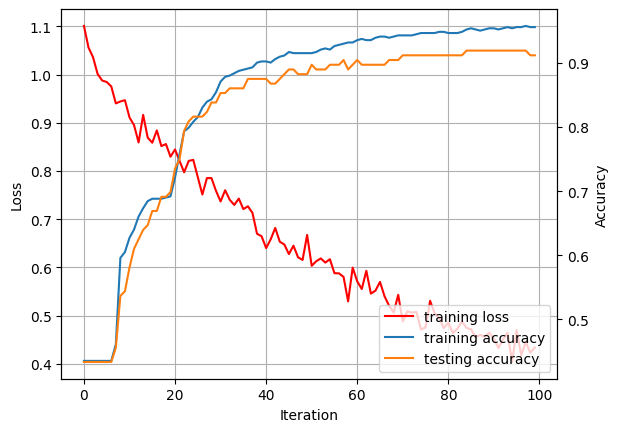

In [145]:
accuracies_train = []
X_train_transformed = gbc_pipeline_model["preprocessor"].transform(X_train)
for y_pred_train in gbc_pipeline_model["model"].staged_predict(X_train_transformed):
    acc = accuracy_score(y_train, y_pred_train)
    accuracies_train.append(acc)

accuracies_test = []
X_test_transformed = gbc_pipeline_model["preprocessor"].transform(X_test)
for y_pred_test in gbc_pipeline_model["model"].staged_predict(X_test_transformed):
    acc = accuracy_score(y_test, y_pred_test)
    accuracies_test.append(acc)

loss_values = gbc_pipeline_model["model"].oob_scores_

fig, ax = plt.subplots()
line1, = ax.plot(loss_values, label="training loss", color="r")
ax.set_ylabel("Loss")
ax.set_xlabel("Iteration")
ax.grid(True)
ax2 = ax.twinx()
line2, = ax2.plot(accuracies_train, label="training accuracy")
line3, = ax2.plot(accuracies_test, label="testing accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(handles=[line1, line2, line3])
plt.show()

# Hyper-Parameter Tuning
- Grid-Search on (learning_rate, n_estimators, max_depth, subsample, etc.)

In [148]:
# note: verbosity is listed as hyperparameter to override the model instanciated param verbose=1
param_grid = {
    "model__n_estimators": [100, 200, 500, 1000, 2000],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__verbose": [0],
    "model__subsample": [0.6, 0.8, 1]
}

gbc_gs_pipeline_model = GridSearchCV(estimator=gbc_pipeline_model,
                                     param_grid=param_grid,
                                     cv=5,
                                     refit=True,
                                     scoring="accuracy",
                                     verbose=4)

gbc_gs_pipeline_model.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__subsample=0.6, model__verbose=0;, score=0.624 total time=   0.8s
[CV 2/5] END model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__subsample=0.6, model__verbose=0;, score=0.569 total time=   1.4s
[CV 3/5] END model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__subsample=0.6, model__verbose=0;, score=0.593 total time=   0.8s
[CV 4/5] END model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__subsample=0.6, model__verbose=0;, score=0.630 total time=   0.6s
[CV 5/5] END model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__subsample=0.6, model__verbose=0;, score=0.519 total time=   0.6s
[CV 1/5] END model__learning_rate=0.001, model__max_depth=3, model__n_estimators=100, model__subsample=0.8, model__verbose=0;, score=0.615 total ti

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['relLeftShoulderX',
                                                                          'relLeftShoulderY',
                                                                          'relLeftElbowX',
                                                                          'relLeftElbowY',
                                                                          'relLeftWristX',
                                                                          'relLeftWristY',
                                                                          'relRightShoulderX',
                                                                          'relRightShoulderY',
                                                                          'relRightElbowX',
                                                                          'relRightElbowY',
                                                                          'relRightWristX',
                                                                          'relRightWristY',
                                                                          'indexInSequence']),...
                                                                          'relRightElbowX',
                                                                          'relRightElbowY',
                                                                          'relRightWristX',
                                                                          'relRightWristY'])])),
                                       ('model',
                                        GradientBoostingClassifier(learning_rate=0.01,
                                                                   subsample=0.8,
                                                                   verbose=1))]),
             param_grid={'model__learning_rate': [0.001, 0.01, 0.1],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__n_estimators': [100, 200, 500, 1000, 2000],
                         'model__subsample': [0.6, 0.8, 1],
                         'model__verbose': [0]},
             scoring='accuracy', verbose=4)

In [149]:
gbc_gs_pipeline_model.best_score_

0.9187903499830105

In [151]:
gbc_gs_pipeline_model.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 2000,
 'model__subsample': 0.6,
 'model__verbose': 0}

In [153]:
gbc_gs_pipeline_model.best_estimator_.score(X_test, y_test)

0.9338235294117647

[Text(0, 0, 'forehand'), Text(0, 1, 'backhand'), Text(0, 2, 'serve')]

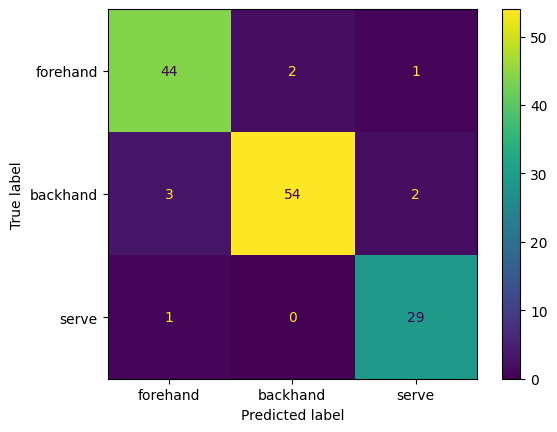

In [155]:
conf_matrix_plot = ConfusionMatrixDisplay.from_estimator(gbc_gs_pipeline_model.best_estimator_, X_test, y_test)
conf_matrix_plot.ax_.set_xticklabels(class_mapping.keys())
conf_matrix_plot.ax_.set_yticklabels(class_mapping.keys())

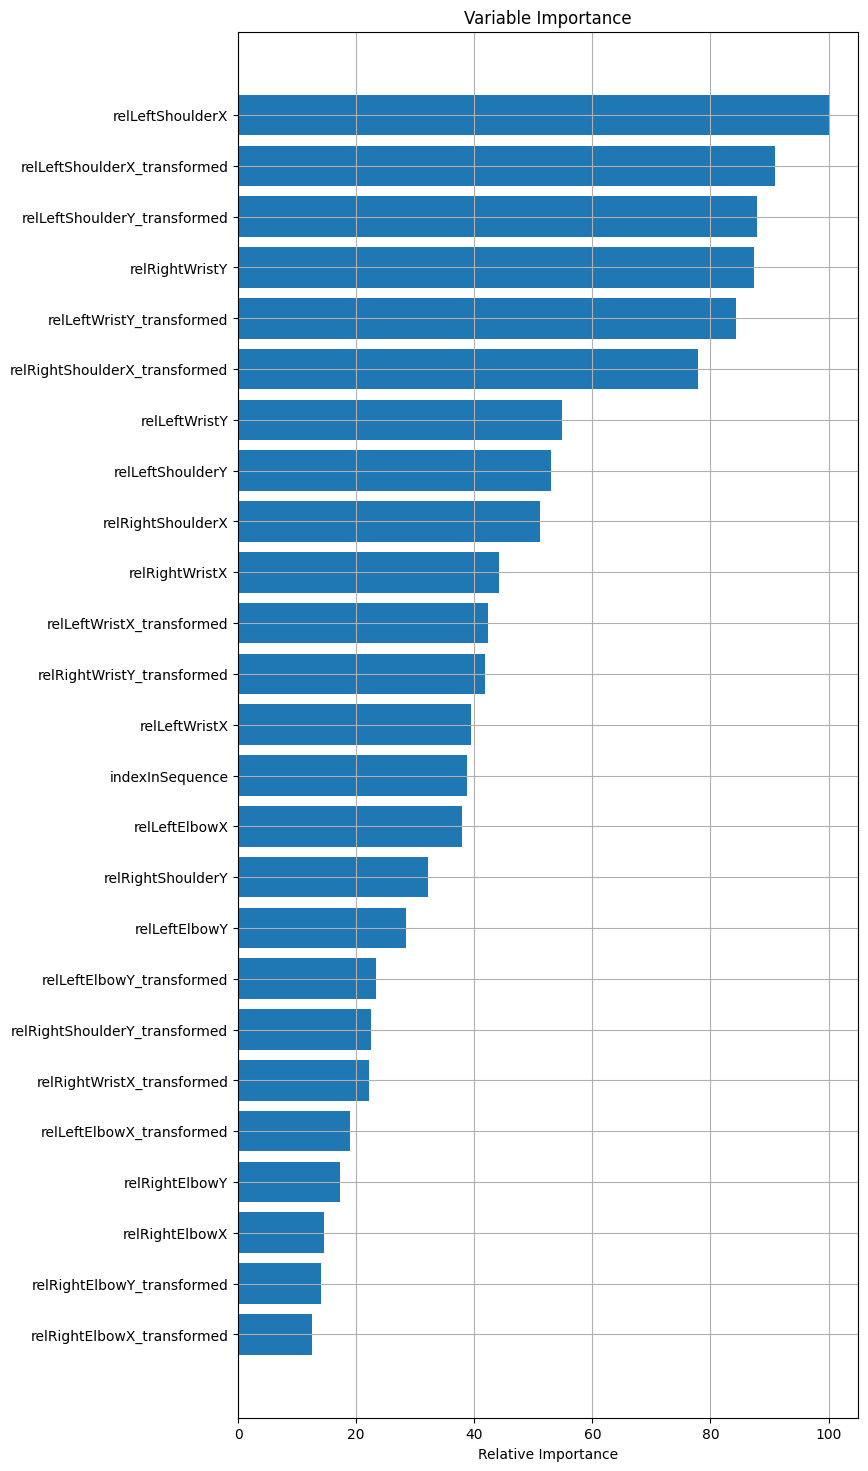

In [184]:
feature_importance = gbc_gs_pipeline_model.best_estimator_["model"].feature_importances_

all_columns = np.array(all_input_channels + [f"{x}_transformed" for x in channels_to_power_transform])


feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, all_columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid(True)
plt.show()

# Summary
A gradient boost classifier has been trained to classify some body part positions relative to the hip center to tennis stroke types. 

## Open tasks
Use more different pose estimation models to improve the classifier. The classifier should be able to learn the tennis stroke type by only knowing the key body part positions. 
If the model is capable of doing so, it will be completely agnostic to any input models. The only thing one need to do then is to build or find a model, which can detect the required key body parts for this classifier.
The used pose estimation model was not properly validated. The model was good enough, to create a first prototype. After the data augmentation it became clear, that this pose estimation model might not be the best one to use.